In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from transformers import TFViTModel

In [17]:
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
train_directory = "images/TRAIN/"
val_directory = "images/TEST/"

In [3]:
# Load datasets
train_dataset = image_dataset_from_directory(
    train_directory,
    image_size=(224,224),
    label_mode="categorical",  # Ensure this matches your model's output
    batch_size=32,
    shuffle=True,
)

val_dataset = image_dataset_from_directory(
    val_directory,
    image_size=(224,224),
    label_mode="categorical",  # Ensure this matches your model's output
    shuffle=True,
)





Found 9957 files belonging to 4 classes.
Found 2487 files belonging to 4 classes.


2024-08-18 18:04:07.981991: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-08-18 18:04:07.982022: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-18 18:04:07.982035: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-18 18:04:07.982054: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-18 18:04:07.982074: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# Load the ViT model
base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# Define the custom Keras layer
class ViTWrapper(tf.keras.layers.Layer):
    def __init__(self, vit_model, **kwargs):
        super(ViTWrapper, self).__init__(**kwargs)
        self.vit_model = vit_model

    def call(self, inputs, **kwargs):
        if not isinstance(inputs, tf.Tensor):
            inputs = tf.convert_to_tensor(inputs)
        outputs = self.vit_model(inputs, return_dict=True)
        return outputs.last_hidden_state

# Define the preprocessing layer
resize_rescale_hf = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Permute((3,1,2))
], name="data_resize_rescale")


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [5]:
# Define the input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3))

# Apply resizing and rescaling
x = resize_rescale_hf(inputs)

# Wrap the ViT model
vit_wrapper = ViTWrapper(vit_model=base_model)

# Pass the preprocessed inputs through the ViT model
x = vit_wrapper(x)

# Extract the [CLS] token representation
x = x[:, 0, :]

# Add a Dense layer for classification
NUM_CLASSES = 4  # Update this to match the number of classes in your dataset
output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
hf_model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model
hf_model.compile(optimizer='adam',
                 loss='categorical_crossentropy',  # Ensure this matches your label_mode
                 metrics=['accuracy'])

# Print model summary to verify
hf_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_resize_rescale             │ (None, 3, 224, 224)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_wrapper (ViTWrapper)       │ (None, 197, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item (GetItem)              │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         3,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,076 (12.02 KB)

 Trainable params: 3,076 (12.02 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)


# Fit the model
history = hf_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks = [early_stopping]
)

Epoch 1/20


2024-08-18 18:04:13.810619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


312/312 ━━━━━━━━━━━━━━━━━━━━ 222s 695ms/step - accuracy: 0.6090 - loss: 1.0307 - val_accuracy: 0.7238 - val_loss: 0.7688
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 226s 723ms/step - accuracy: 0.7607 - loss: 0.6684 - val_accuracy: 0.7563 - val_loss: 0.6841
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 209s 669ms/step - accuracy: 0.8021 - loss: 0.5753 - val_accuracy: 0.7559 - val_loss: 0.6632
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 209s 670ms/step - accuracy: 0.8273 - loss: 0.5213 - val_accuracy: 0.7756 - val_loss: 0.6243
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 208s 668ms/step - accuracy: 0.8442 - loss: 0.4767 - val_accuracy: 0.7668 - val_loss: 0.6090
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 209s 669ms/step - accuracy: 0.8541 - loss: 0.4470 - val_accuracy: 0.7736 - val_loss: 0.5847
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 208s 668ms/step - accuracy: 0.8632 - loss: 0.4210 - val_accuracy: 0.7716 - val_loss: 0.5700
Epoch 8/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 209s 669ms/step - accuracy: 0.8695 - loss: 0.39

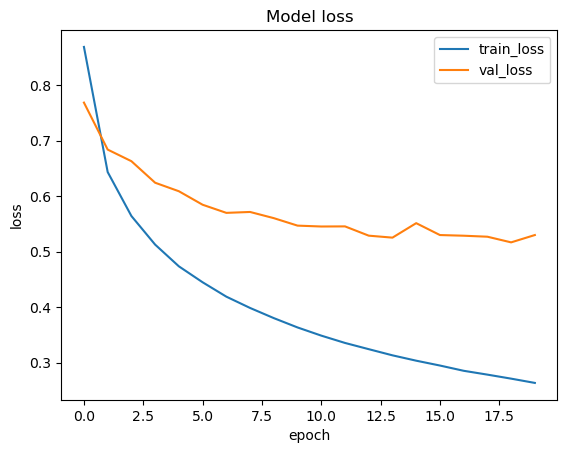

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

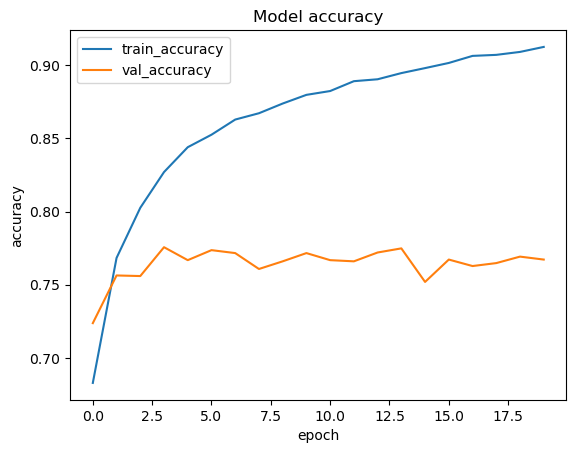

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [23]:
hf_model.evaluate(val_dataset)

78/78 ━━━━━━━━━━━━━━━━━━━━ 44s 559ms/step - accuracy: 0.7724 - loss: 0.5100


[0.5168572664260864, 0.7691998481750488]